In [ ]:
import praw
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Download stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Step 1: Reddit API Authentication
reddit = praw.Reddit(
    client_id='qkJ1JITIA2VEPg2LGgIw4g',
    client_secret='bJ2-Go_eYttm1PcsOkEKW-2aOSRQBw',
    user_agent='GiveGoa project/1.0 (by u/dvk_reports2503)')   

# Step 2: Scrape Subreddit Posts
subreddit = reddit.subreddit('Goa')
posts = []
for post in subreddit.hot(limit=1000):  # Fetch top 1000 hot posts
    posts.append(post.title + ' ' + post.selftext)  # Combine title and text

# Step 3: Text Preprocessing Function
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove emails
    text = re.sub(r'\'', '', text)  # Remove apostrophes
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to all posts
cleaned_posts = [preprocess_text(post) for post in posts]

# Step 4: Convert Text into TF-IDF Features
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(cleaned_posts)

# Step 5: Apply K-Means Clustering
num_topics = 10  # Adjust as needed
kmeans = KMeans(n_clusters=num_topics, random_state=42, n_init=10)
kmeans.fit(X)

# Step 6: Extract Top Terms in Each Topic Cluster
terms = vectorizer.get_feature_names_out()
topic_keywords = []
for i in range(num_topics):
    topic_terms = [terms[idx] for idx in kmeans.cluster_centers_[i].argsort()[-10:]]
    topic_keywords.append(topic_terms)

# Step 7: Display Results
for i, keywords in enumerate(topic_keywords):
    print(f"Topic {i+1}: {', '.join(keywords)}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADVIK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 1: last, place, internet, fish, nuste, thali, today, christmas, guess, sunset
Topic 2: want, keep, respectful, whatever, welcome, tech, tuesday, free, friday, talk
Topic 3: know, anyone, meetup, litter, interfaith, wedding, kakolem, near, goa, beach
Topic 4: one, place, kind, boi, anyone, share, really, service, goa, good
Topic 5: one, north, like, people, state, see, im, goans, goa, south
Topic 6: dogs, time, https, watch, konkani, car, local, goa, get, goan
Topic 7: looking, im, anyone, would, week, know, goa, help, please, need
Topic 8: like, people, want, would, work, know, year, looking, new, goa
Topic 9: hoping, owl, belong, cuckoo, know, nice, pic, species, feather, bird
Topic 10: around, groups, play, pm, com, sunday, football, seqc, quiz, panjim


In [23]:
!pip install wordcloud


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


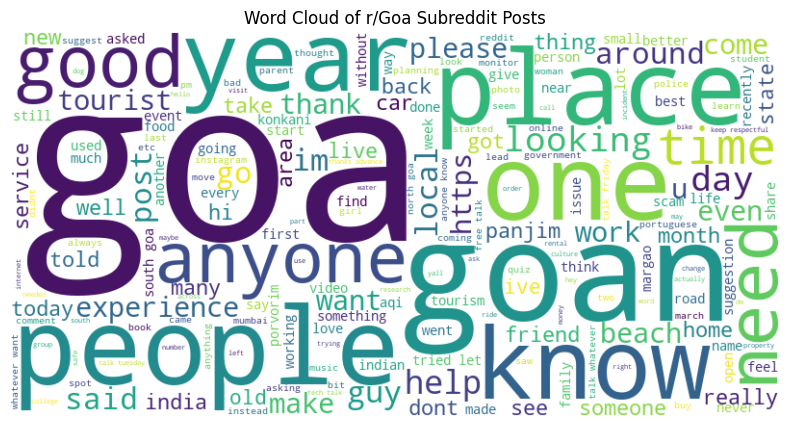

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud_text = ' '.join(cleaned_posts)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

# Display Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of r/Goa Subreddit Posts")
plt.show()

## TEXTBLOB sentiment analysis

-> Rule-based + Naive Bayes method

-> Uses predefined word lists with polarity scores

-> Works well for simple sentiment classification

-> Fails with sarcasm and complex language

In [49]:
from textblob import TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns value between -1 (negative) to +1 (positive)

sentiments = [get_sentiment(post) for post in cleaned_posts]
df = pd.DataFrame({'Post': cleaned_posts, 
                   'Sentiment': sentiments
                   })

# Display average sentiment score
avg_sentiment = df['Sentiment'].mean()
print(f"Average Sentiment Score: {avg_sentiment:.2f}")


Average Sentiment Score: 0.13


In [75]:
df.head()

,Post,Sentiment
0,events rental pgs jobs internships classifieds...,0.162500
1,free talk friday march welcome free talk frida...,0.525000
2,really care award save downfall goa tourism de...,0.200000
3,vape stores goa im looking vape vendors goa do...,-0.066667
4,supreme court know forests destroyed goa supre...,-0.053693


In [55]:
print("Number of positive sentiments =", sum(df['Sentiment'] > 0))
print("Number of neutral sentiments =", sum(df['Sentiment'] == 0))
print("Number of negative sentiments =", sum(df['Sentiment'] < 0))

Number of positive sentiments = 511
Number of neutral sentiments = 277
Number of negative sentiments = 140


## VADER sentiment analysis

-> Lexicon-based + Heuristics

-> Designed for social media and short text

-> Uses heuristics (e.g., emphasis on capitalization, exclamation marks)

-> Limited to pre-defined words, cannot learn new sentiment words

In [76]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon if not already available
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER Sentiment Scoring
df['VADER Sentiment'] = df['Post'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Classify Sentiments
df['Positive Sentiment'] = df['VADER Sentiment'].apply(lambda x: 1 if x > 0 else 0)
df['Neutral Sentiment'] = df['VADER Sentiment'].apply(lambda x: 1 if x == 0 else 0)
df['Negative Sentiment'] = df['VADER Sentiment'].apply(lambda x: 1 if x < 0 else 0)

# Print Sentiment Counts
print(f"Number of positive sentiment: {df['Positive Sentiment'].sum()}")
print(f"Number of neutral sentiment: {df['Neutral Sentiment'].sum()}")
print(f"Number of negative sentiment: {df['Negative Sentiment'].sum()}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ADVIK\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Number of positive sentiment: 530
Number of neutral sentiment: 234
Number of negative sentiment: 164


## ROBERTA sentiment anaysis

-> Uses deep learning(transformers)

-> Complex nuanced text with deep context 

-> Captures deep meaning, sarcasm, and complex sentiments

-> More accurate than rule-based methods but requires high computing power

In [ ]:
from transformers import pipeline

sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

def truncate_text(text, max_length=512):
    tokens = preprocess_text(text)  
    return tokens[:max_length]  # Keep only the first 512 tokens

df['Truncated Post'] = df['Post'].apply(truncate_text)

# Apply RoBERTa Sentiment Analysis on truncated text
df['RoBERTa Sentiment'] = df['Truncated Post'].apply(lambda text: sentiment_model(text)[0]['label'])

print(df['RoBERTa Sentiment'].value_counts())

Device set to use cpu


RoBERTa Sentiment
LABEL_1    549
LABEL_2    241
LABEL_0    138
Name: count, dtype: int64


## BERT sentiment analysis

-> Similar to RoBERTa but lighter and works well for general sentiment tasks

-> It is not optimized for social media text

In [84]:
sentiment_model_2 = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Apply BERT Sentiment Analysis
df['BERT Sentiment'] = df['Truncated Post'].apply(lambda text: sentiment_model_2(text)[0]['label'])

# Print Sentiment Counts
print(df['BERT Sentiment'].value_counts())


Device set to use cpu


BERT Sentiment
1 star     376
5 stars    262
4 stars    138
3 stars    115
2 stars     37
Name: count, dtype: int64


In [88]:
# Define sentiment categories based on BERT star ratings
positive_count = df['BERT Sentiment'].apply(lambda x: 1 if x in ['4 stars', '5 stars'] else 0).sum()
neutral_count = df['BERT Sentiment'].apply(lambda x: 1 if x == '3 stars' else 0).sum()
negative_count = df['BERT Sentiment'].apply(lambda x: 1 if x in ['1 star', '2 stars'] else 0).sum()

# Print sentiment summary
print(f"Number of Positive Sentiment Posts (4 & 5 stars): {positive_count}")
print(f"Number of Neutral Sentiment Posts (3 stars): {neutral_count}")
print(f"Number of Negative Sentiment Posts (1 & 2 stars): {negative_count}")


Number of Positive Sentiment Posts (4 & 5 stars): 400
Number of Neutral Sentiment Posts (3 stars): 115
Number of Negative Sentiment Posts (1 & 2 stars): 413
